In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Display the row's columns and data in dictionary format
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x10bca0550>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0}

In [11]:
# Display the row's columns and data in dictionary format
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x10bcaf0f0>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [12]:
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Find the Lastest Date from the Dataset
lastest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
lastest_date

('2017-08-23')

In [14]:
#last 12 months range begin date
start_date = dt.date(2017, 8 ,23) - dt.timedelta(days=365)
print(start_date)

2016-08-23


In [15]:
# Calculate the date 1 year ago from today
year_ago_today = dt.date.today() - dt.timedelta(days=365)
print(year_ago_today)

2017-09-01


In [16]:
# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date,func.avg(Measurement.prcp)).filter(Measurement.date>=start_date).\
group_by(Measurement.date).all()


In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df_prcp = pd.DataFrame(prcp_data[:], columns=['Date','Precipitation'])
df_prcp = df_prcp.set_index('Date')
# Sort the dataframe by date
df_prcp.sort_values(by=['Date'])
df_prcp.head()

,Precipitation
Date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000


<IPython.core.display.Javascript object>


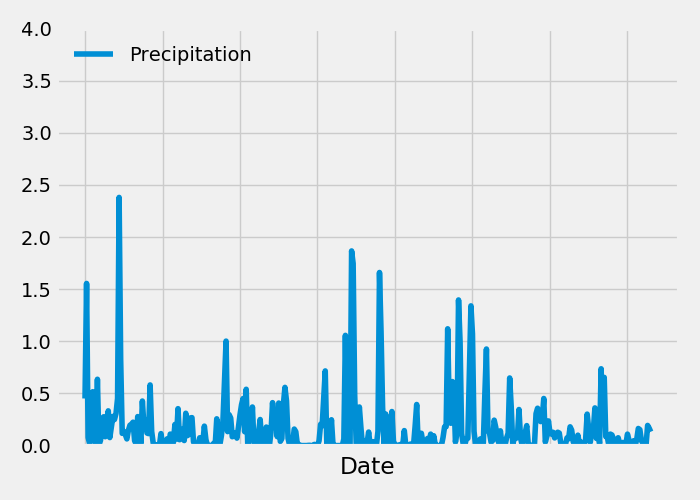

In [39]:
# Use Pandas Plotting with Matplotlib to plot the data
plt_prcp = df_prcp.plot ( figsize=(7,5))
# Rotate the xticks for the dates
plt.xticks(rotation=90)
plt_prcp.legend(loc='upper left', frameon=False)
plt.ylim(0, 4)
plt.tight_layout()
plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_prcp.describe()

,Precipitation
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [20]:
# How many stations are available in this dataset?
session.query(func.count(Station.station)).all()


[(9)]

In [21]:
session.query(Station.station, Station.id).all()

[('USC00519397', 1),
 ('USC00513117', 2),
 ('USC00514830', 3),
 ('USC00517948', 4),
 ('USC00518838', 5),
 ('USC00519523', 6),
 ('USC00519281', 7),
 ('USC00511918', 8),
 ('USC00516128', 9)]

In [22]:
# What are the most active stations?
most_active_stat =session.query(Measurement.station).group_by(Measurement.station).\
order_by(func.count(Measurement.id).desc()).first()
most_active_stat=list(most_active_stat)[0]
print(most_active_stat)
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.id)).group_by(Measurement.station).\
order_by(func.count(Measurement.id).desc()).all()

USC00519281


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [85]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station== most_active_stat).all()

[(54.0, 85.0, 71.66378066378067)]

In [86]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
tobs = session.query(Measurement.tobs).filter(Measurement.station== most_active_stat)\
.filter(Measurement.date>=start_date).all()
tobs_list = []
for tob in tobs:
    tobs_list.append(tob[0])
df_tobs = pd.DataFrame(tobs_list[:], columns=['tobs'])

<IPython.core.display.Javascript object>


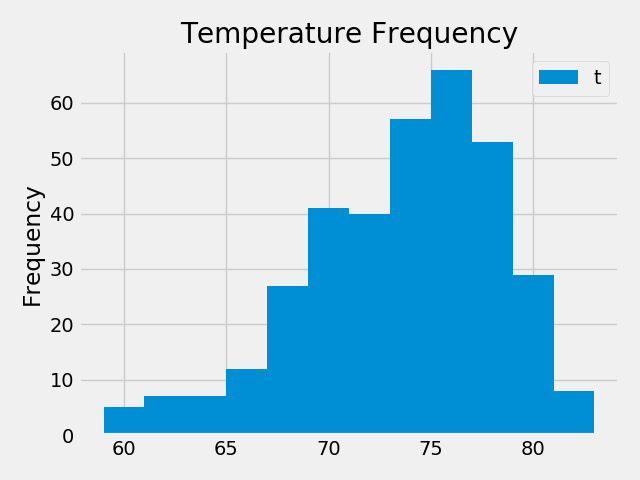

In [88]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
df_tobs.hist("tobs",bins=12)
plt.title ("Temperature Frequency")
plt.ylabel("Frequency")
plt.legend("tobs")
plt.tight_layout()
plt.show()

In [107]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [108]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2016-08-23'
end_date = '2017-8-23'
TMIN = calc_temps(start_date, end_date)[0][0]
TAVG = calc_temps(start_date, end_date)[0][1]
TMAX = calc_temps(start_date, end_date)[0][2]
print(TMIN, TAVG, TMAX)

58.0 74.59058295964125 87.0


<IPython.core.display.Javascript object>


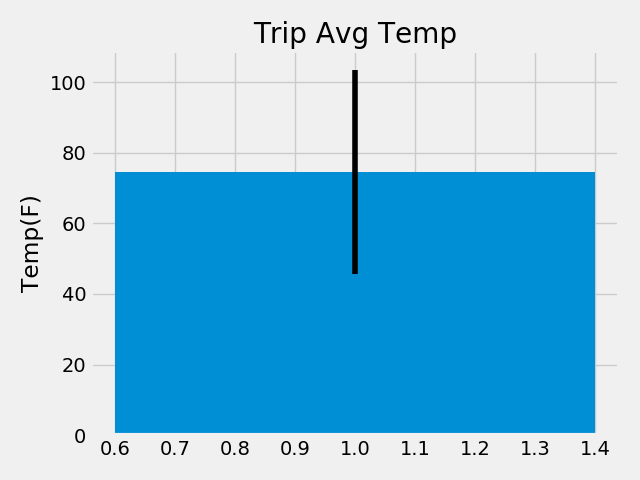

In [101]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(5)
plt.bar(1,height=TAVG, yerr=(TMAX-TMIN))
plt.ylabel('Temp(F)')
plt.title('Trip Avg Temp')
plt.tight_layout()
plt.show()

In [106]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall = session.query(Station.station,Station.name, Station.latitude,Station.longitude,Station.elevation,func.avg(Measurement.prcp))\
.filter(Station.station == Measurement.station).filter(Measurement.date>=start_date).group_by(Measurement.date).\
order_by (func.avg(Measurement.prcp).desc(),Station.station ).all()
rainfall

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  2.3800000000000003),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.866666666666667),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.7466666666666668),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.6600000000000001),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.5549999999999997),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.3966666666666667),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.3399999999999999),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.1199999999999999),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.0933333333333333),
 ('USC00516128',
  'MANOA LYON ARBO 78

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


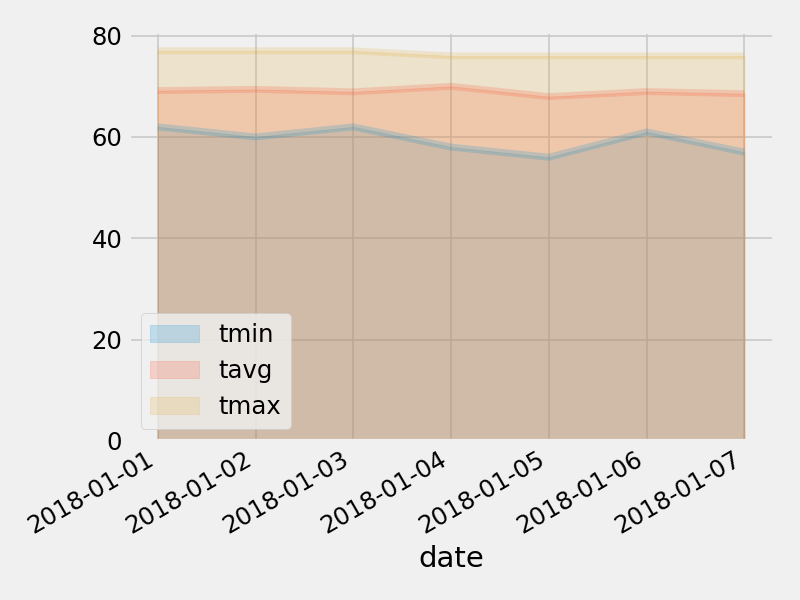

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
